In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
from matplotlib import pyplot as plt, colors, ticker
from tqdm import tqdm_notebook as tqdm
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from itertools import chain
from nltk import NaiveBayesClassifier
from nltk.classify import accuracy
from nltk.metrics.scores import f_measure, precision, recall
import re
import string
import collections
import pickle
pos = open("positive_emoji_v2.csv").read().split(",")
neg = open("negative_emoji_v2.csv").read().split(",")
#print("Positive emoji: {}\n\nNegative emoji: {}\n".format("".join(pos), "".join(neg)))
files = sorted(glob.glob("egypt tweets/egypt_tweets*.csv"))
#print(files)
pd.set_option('display.max_colwidth', -1)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

In [2]:
%%time
try:
    train = pd.read_csv("train.csv", sep=";", engine="python")
except:
    train = []
    for f in tqdm(files):
        df = pd.read_csv(f, sep=";")
        feels = np.zeros(len(df), dtype=int)
        for i in tqdm(range(len(df))):
            html = df.html[i]
            if type(html) != str:
                continue
            feel = sum([e in html for e in pos]) - sum([e in html for e in neg])
            feels[i] = feel
        df["feel"] = feels
        train.append(df[df.feel != 0])
    train = pd.concat(train)
    print(len(train))
    text_with_emoji = np.empty(len(train), dtype=object)
    for i, html in enumerate(tqdm(train.html)):
        soup = BeautifulSoup(html, "lxml")
        s = []
        for child in soup.find("p").children:
            if child.name == None:
                s.append(child)
            elif child.name == "img":
                s.append(child["alt"])
            else:
                s.append(child.text)
        text_with_emoji[i] = " ".join(s)
    train.text = text_with_emoji
    train[["text", "feel"]].to_csv("train.csv", sep=";", index=False)

CPU times: user 2.32 s, sys: 154 ms, total: 2.47 s
Wall time: 2.48 s


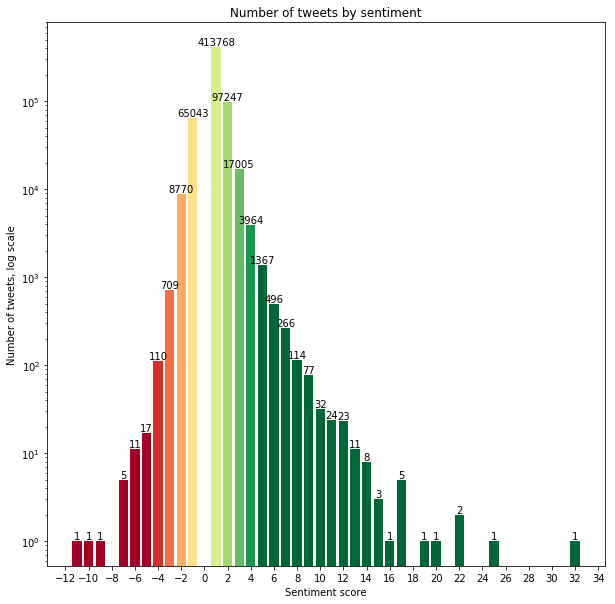

In [3]:
tvc = train.feel.value_counts().sort_index()
values = tvc.values
keys = tvc.keys()

plt.figure(figsize = (10,10))
cmap = plt.cm.RdYlGn
norm = colors.Normalize(vmin=-5, vmax=5)
plt.bar(keys, values, color=cmap(norm(keys)))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.gca().set_yscale('log')
plt.title("Number of tweets by sentiment")
plt.ylabel("Number of tweets, log scale")
plt.xlabel("Sentiment score")

for i, v in enumerate(values):
    k = keys[i]
    plt.text(k, v, v, ha="center", va="bottom")

In [4]:
word_frequencies = {}
for tweet in tqdm(train.text):
    for word in tweet.split():
        word_frequencies[word] = word_frequencies.get(word, 0) + 1

words_by_popularity = sorted(word_frequencies.items(), key=lambda kv: kv[1], reverse=True)
word_frequencies = pd.DataFrame(words_by_popularity, columns=["Word", "Count"])
display(word_frequencies.head(20))

,Word,Count
0,😂,636243
1,…,99283
2,❤,66171
3,❤️,63859
4,و,57607
5,من,56550
6,يا,53606
7,♥️,48580
8,انا,48154
9,😍,44950


In [5]:
vocab = set(word_frequencies[word_frequencies.Count > 100].Word) - set(pos) - set(neg)
print(len(vocab))
train_feat = []
for i in tqdm(range(len(train))):
    tweet = train.text[i]
    label = "pos" if train.feel[i] > 0 else "neg"
    words = tweet.split()
    train_feat.append(({word: word in words for word in vocab}, label))
np.random.shuffle(train_feat)
print(len(train_feat))

5018



610907


In [13]:
#i = int(len(train_feat) * .25)
i = 10000
xtrain = train_feat[i:]
xtest = train_feat[:i]
print(len(xtrain), len(xtest))

600907 10000


In [14]:
%%time
classifier = nltk.NaiveBayesClassifier.train(xtrain)
with open('sentiment_classifier_model.pickle', 'wb') as f:
    pickle.dump({
        "vocab": vocab,
        "model": classifier
    }, f)

CPU times: user 55min 24s, sys: 22.3 s, total: 55min 47s
Wall time: 55min 59s


In [15]:
classifier.show_most_informative_features()

Most Informative Features
                     :(( = True              neg : pos    =   1174.9 : 1.0
                   🙇🏻‍♀️ = True              neg : pos    =    210.3 : 1.0
                      ♥️ = True              pos : neg    =    128.2 : 1.0
                      ☹️ = True              neg : pos    =    122.6 : 1.0
                      💃🏻 = True              pos : neg    =     79.5 : 1.0
                      ❗️ = True              neg : pos    =     74.8 : 1.0
                      ❤️ = True              pos : neg    =     64.9 : 1.0
                  وعقبال = True              pos : neg    =     54.0 : 1.0
                     rts = True              pos : neg    =     45.5 : 1.0
                    :))) = True              pos : neg    =     43.2 : 1.0


In [16]:
%%time
print("Accuracy: {}".format(accuracy(classifier, xtest)))

Accuracy: 0.851
CPU times: user 2min 17s, sys: 368 ms, total: 2min 18s
Wall time: 2min 18s


In [17]:
def classify(text):
    words = text.split()
    features = {word: word in words for word in vocab}
    return classifier.classify(features)
for tweet in np.random.choice(train.text, 20, replace=False):
    display(tweet)
    print(classify(tweet))

'@NoriAhmed  مش معقوووول  😲'

pos


'اصلي يا رياسه  👌🏻 😂'

pos


'#NewProfiePic   🌸 pic.twitter.com/KOTk9OW6yw'

pos


'@MariOoOmGamal   😒 😒 😒 😒 😒 😒 😒 😒 😒 😒 😒'

pos


'الشناوي 😥 😥'

pos


'في شوية عيال خولات محسوبين علي الكورة مشجعين عشان طلعوا لقيوا ابوهم زملكاوي ، بيقعدوا يظيطوا كتير و في اللحظات دي بيعملوا هُبل  😂'

pos


'الله يبارك فيك يا رائد عبالك يارب ان شاءالله 💙 🌸'

pos


'كراااااشي الاول والاخير اسروه حبيبي عماله اوزعلو في ابتسامات من ساعة ما شوفتو  😂 😂 😂 😂 😂 😂 😂 ❤️ ❤️'

pos


'لا بس اقسم بالله انا صممت ودفعت \nهو مصدق ومشي  😂 😂 😂'

pos


'😂 😂 😂'

pos


'بالضبط اوي 😂 😂 😂 😂 😂 🙆🏻\u200d♀️ https://twitter.com/omarhagag7/status/1134134248594640902\xa0…'

pos


'فرحتنى لما عرفت ان مش لوحدى اللى مبذاكرش  😂 😂 😂 💃'

pos


'من يومها بدأت أول قصتنا\nفي كتاب الحب اتولدت رقصتنا ♥️ 🎶'

pos


'لا اقتنعت خلاص  😂 😂 😂 👏'

pos


'@boddyosama202 \n #تويب_تقولة_كل_سنة_وانت_طيب \n ♥'

pos


'💖 💖 💖 https://twitter.com/KarimHegap/status/1149809065612251136\xa0…'

pos


'شكرا ياصحبتي  💔'

pos


'ما شاء الله قمر  ❤ ❤ ❤ https://twitter.com/osamaarafaa/status/1151979142008791043\xa0…'

pos


'كل دا عشان انا صحيت م النوم\u2066 ♥️ \u2069 😂 😂 😂 😂 😂'

pos


'بسم الله الرحمن الرحيم (وَلَئِن سَأَلْتَهُمْ لَيَقُولُنَّ إِنَّمَا كُنَّا نَخُوضُ وَنَلْعَبُ ۚ قُلْ أَبِاللَّهِ وَآيَاتِهِ وَرَسُولِهِ كُنتُمْ تَسْتَهْزِئُونَ)صدق الله العظيم ....يااسفاااه   😭 💔'

pos
